# Test the performance of MDM vs QDM + Sort for the globe

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
import random

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [2]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
#########
locn   = 'chicago'
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
cesm2_path        = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals             = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
cmip6_cvals       = cvals + 'cmip6/'
#cvals_det     = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
############
pi_year  = 1865
eoc_year = 2086
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [3]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date

'July 30'

In [4]:
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  

In [5]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile','model_id','obs_id'}
    return (ds * weight).mean(other_dims)

In [6]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(2)

In [8]:
cluster

Dashboard: http://10.0.39.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.4:32845,Workers: 0
Dashboard: http://10.0.39.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Compare QDM + Sort and MDM 

### Load CESM2 data

In [9]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 3.02 s, sys: 450 ms, total: 3.47 s
Wall time: 3.64 s


In [10]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tpi   = ds_hist.TREFHTMX.sel(method='nearest').sel(time=slice(pi_year0,pi_year1))

teoc  = ds_ssp.TREFHTMX.sel(method='nearest').sel(time=slice(ic_year0,ic_year1))

CPU times: user 876 ms, sys: 44.5 ms, total: 921 ms
Wall time: 896 ms


In [11]:
tdpi  = to_daily(tpi)
tdeoc = to_daily(teoc)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

In [12]:
######################

In [13]:
# Total range of numbers
total_range = list(range(1, 100))

# Generate the first list of N unique random numbers
N = 8
random.seed(42) 
model_list = random.sample(total_range, N)

# Remove these numbers from the total range to avoid repetition
remaining_range = [num for num in total_range if num not in model_list]

# Generate the second list of 10 unique random numbers from the remaining numbers
obs_list = random.sample(remaining_range, N)

model_list = model_list + [99,0]
obs_list   = obs_list + [0,99]

# Pair the numbers together
paired_numbers = list(zip(model_list, obs_list))
#

# Print the pairs
print("List of pairs:")
for pair in paired_numbers:
    print(pair)

List of pairs:
(82, 16)
(15, 94)
(4, 76)
(95, 13)
(36, 83)
(32, 61)
(29, 6)
(18, 5)
(99, 0)
(0, 99)


### Select Observation and Model indices. Detrend data.

In [14]:
############ Select some ensemble as obs and another as model ######
#
pi_obs  = tdpi.sel(member = obs_list)
eoc_obs = tdeoc.sel(member= obs_list)
#
#
pi_model_det  = xr.open_zarr(cvals+'pi_detrended.zarr').detrended_tmax
eoc_model_det = xr.open_zarr(cvals+'eoc_detrended.zarr').detrended_tmax
#
pi_model_det  = pi_model_det.sel(member = model_list)
eoc_model_det = eoc_model_det.sel(member = model_list)
#
pi_model  = tdpi.sel(member = model_list)
eoc_model = tdeoc.sel(member = model_list)
#
pi_model  = pi_model.chunk({'lat':8,'lon':60,'member':-1,'year':10,'dayofyear':73})
eoc_model = eoc_model.chunk({'lat':8,'lon':60,'member':-1,'year':10,'dayofyear':73})
pi_obs    = pi_obs.chunk({'lat':8,'lon':60,'member':-1,'year':10,'dayofyear':73})
eoc_obs   = eoc_obs.chunk({'lat':8,'lon':60,'member':-1,'year':10,'dayofyear':73})
# eoc_obs

In [15]:
pi_model  = pi_model.rename({'member':'model_id'})
eoc_model = eoc_model.rename({'member':'model_id'})
#
pi_model_det  = pi_model_det.rename({'member':'model_id'})
eoc_model_det = eoc_model_det.rename({'member':'model_id'})
#
pi_obs     = pi_obs.rename({'member':'obs_id'})
eoc_obs    = eoc_obs.rename({'member':'obs_id'})

In [16]:
pi_omean  = pi_obs.mean('year')
#
pi_mmean  = pi_model_det.mean('year')
pi_mstd   = pi_model_det.std('year')
#
eoc_mmean = eoc_model_det.mean('year')
eoc_mstd  = eoc_model_det.std('year')
pi_mmean

<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, model_id: 10,
                                    dayofyear: 365)>
dask.array<mean_agg-aggregate, shape=(192, 288, 10, 365), dtype=float64, chunksize=(8, 60, 10, 73), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 220 221 222 223 224 225 ... 142 143 144 145 146
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * model_id   (model_id) int64 82 15 4 95 36 32 29 18 99 0

## Perform Moment Delta Mapping

In [17]:
pi_mdm  = implement_mdm(pi_obs,pi_mmean,eoc_mmean,pi_mstd,eoc_mstd)

In [18]:
qpi_mdm = compute_quantiles(pi_mdm)
#qpi_mdm = qpi_mdm.chunk({'obs_id':-1})
qpi_mdm = qpi_mdm.chunk({'obs_id':1})
qpi_mdm

<xarray.DataArray (quantile: 30, lat: 192, lon: 288, obs_id: 10,
                   dayofyear: 365, model_id: 10)>
dask.array<rechunk-merge, shape=(30, 192, 288, 10, 365, 10), dtype=float64, chunksize=(30, 8, 60, 1, 73, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 16 94 76 13 83 61 6 5 0 99
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * model_id   (model_id) int64 82 15 4 95 36 32 29 18 99 0
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [19]:
# %%time
# qpi_mdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_mdm_216examples.zarr',mode='w')
# qpi_mdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_mdm_27examples.zarr',mode='w')
# qpi_mdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_mdm_100examples.zarr',mode='w')

## Perform Quantile Delta Mapping

In [20]:
qpi_model  = compute_quantiles(pi_model)
qeoc_model = compute_quantiles(eoc_model)
#
qpi_obs  = compute_quantiles(pi_obs)
qeoc_obs = compute_quantiles(eoc_obs)
#
qano     = qeoc_model - qpi_model

In [21]:
qpi_qdm =  qpi_obs + qano
# qpi_qdm = qpi_qdm.chunk({'obs_id':-1})
qpi_qdm = qpi_qdm.chunk({'obs_id':1})
qpi_qdm

<xarray.DataArray 'TREFHTMX' (quantile: 30, lat: 192, lon: 288, obs_id: 10,
                              dayofyear: 365, model_id: 10)>
dask.array<rechunk-merge, shape=(30, 192, 288, 10, 365, 10), dtype=float64, chunksize=(30, 8, 60, 1, 73, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 16 94 76 13 83 61 6 5 0 99
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) int64 82 15 4 95 36 32 29 18 99 0

In [22]:
# %%time
# qpi_qdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_qdm_216examples.zarr',mode='w')
# qpi_qdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_qdm_27examples.zarr',mode='w')
# qpi_qdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_qdm_100examples.zarr',mode='w')

## MDM vs QDM

In [23]:
# qpi_mdm = xr.open_zarr(cvals+'qpi_mdm_27examples.zarr').tmax
# qpi_qdm = xr.open_zarr(cvals+'qpi_qdm_27examples.zarr').tmax
# qpi_mdm = xr.open_zarr(cvals+'qpi_mdm_216examples.zarr').tmax
# qpi_qdm = xr.open_zarr(cvals+'qpi_qdm_216examples.zarr').tmax
qpi_mdm = xr.open_zarr(cvals+'qpi_mdm_100examples.zarr').tmax
qpi_qdm = xr.open_zarr(cvals+'qpi_qdm_100examples.zarr').tmax
qpi_mdm

<xarray.DataArray 'tmax' (quantile: 30, lat: 192, lon: 288, obs_id: 10,
                          dayofyear: 365, model_id: 10)>
dask.array<open_dataset-00d79d6ec4ea364d8285fac21e5f3b44tmax, shape=(30, 192, 288, 10, 365, 10), dtype=float64, chunksize=(30, 8, 60, 1, 73, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * model_id   (model_id) int64 82 15 4 95 36 32 29 18 99 0
  * obs_id     (obs_id) int64 16 94 76 13 83 61 6 5 0 99
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

## Select model and observations and plot

In [24]:
model_index = 0
obs_index   = 99

In [25]:
%%time
#
qpi_mdm_day    = qpi_mdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                  .sel(model_id = model_index).sel(obs_id = obs_index)
#
qpi_qdm_day    = qpi_qdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                    .sel(model_id = model_index).sel(obs_id = obs_index)

CPU times: user 61.1 ms, sys: 7.65 ms, total: 68.7 ms
Wall time: 64.4 ms


In [26]:
qpi_sqdm  = xr.apply_ufunc(
    np.sort,
    qpi_qdm,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
# qpi_sqdm

In [27]:
qpi_sqdm_day = qpi_sqdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                .sel(model_id = model_index).sel(obs_id = obs_index)

In [28]:
# qeoc_model_day = qeoc_model.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(model_id =model_index)
#
qpi_model_day  = qpi_model.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(model_id =model_index)
#
qpi_obs_day    = qpi_obs.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(obs_id =obs_index)
#
qeoc_obs_day   = qeoc_obs.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(obs_id =obs_index)

CPU times: user 51.9 s, sys: 2.6 s, total: 54.5 s
Wall time: 2min 23s


Text(0.05, 0.95, 'obs_index = 99\nmodel_index = 0')

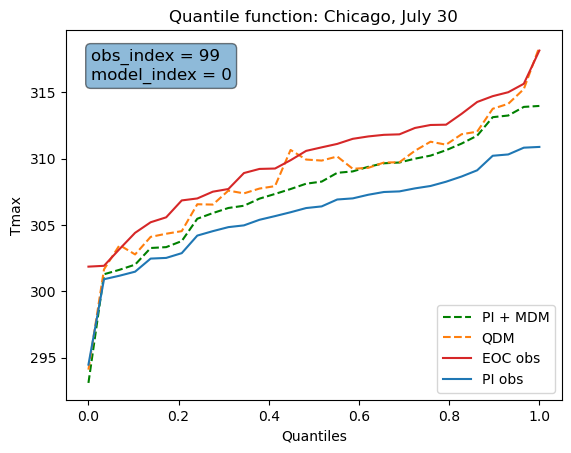

In [29]:
%%time
#
text_str = f'obs_index = {obs_index}\nmodel_index = {model_index}'  # Construct the text string with line breaks
#
plt.plot(quants,qpi_mdm_day,'--',color='green',label='PI + MDM')
plt.plot(quants,qpi_qdm_day,'--',color='tab:orange',label='QDM')
plt.plot(quants,qeoc_obs_day,color='tab:red',label ='EOC obs')
plt.plot(quants,qpi_obs_day,color= 'tab:blue', label ='PI obs')
#
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('Quantile function: Chicago, ' + date)
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

In [30]:
is_sorted(qpi_qdm_day.values)

False

### Plot RMSEs of Sorted + QDM and PI + MDM for globe

In [31]:
# qeoc_obs0 = qeoc_obs.expand_dims(dim={'model_id':model_list}).assign_coords(model_id = qpi_mdm.coords['model_id'])
# qeoc_obs0

In [32]:
# rmse_mdm = xs.rmse(qeoc_obs0,qpi_mdm,dim='quantile')
# rmse_mdm

In [33]:
# rmse_sqdm = xs.rmse(qeoc_obs0,qpi_sqdm,dim='quantile')
# rmse_sqdm

In [34]:
%%time
# rmse_mdm.rename('tmax').to_dataset().to_zarr(cvals+'rmse_mdm_27examples.zarr',mode='w')
# rmse_mdm.rename('tmax').to_dataset().to_zarr(cvals+'rmse_mdm_216examples.zarr',mode='w')

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 29.1 µs


In [35]:
%%time
# rmse_sqdm.rename('tmax').to_dataset().to_zarr(cvals+'rmse_sqdm_27examples.zarr',mode='w')
# rmse_sqdm.rename('tmax').to_dataset().to_zarr(cvals+'rmse_sqdm_216examples.zarr',mode='w')

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 24.3 µs


In [36]:
%%time
# rmse_mdm  = xr.open_zarr(cvals+'rmse_mdm_27examples.zarr').tmax
# rmse_sqdm = xr.open_zarr(cvals+'rmse_sqdm_27examples.zarr').tmax
#
# rmse_mdm  = xr.open_zarr(cvals+'rmse_mdm_216examples.zarr').tmax
# rmse_sqdm = xr.open_zarr(cvals+'rmse_sqdm_216examples.zarr').tmax

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 26.7 µs


In [37]:
# rmse_mdm_day  = rmse_mdm.sel(model_id=model_index).sel(obs_id=obs_index).sel(dayofyear=doy)
# rmse_sqdm_day = rmse_sqdm.sel(model_id=model_index).sel(obs_id=obs_index).sel(dayofyear=doy)

In [38]:
# %%time
# rmse_mdm_day.plot(cmap='RdBu_r')

In [39]:
# rmse_sqdm_day.plot(cmap='RdBu_r')

- Test if model_index and obs_index are same, rmse for Sorted QDM should be zero

In [40]:
# rmse_sqdm_day.values

### Compute global mean of absolute error 
- Quantile function after applying mdm on model pre-ind quantile function is denoted qpi_mdm using some qeoc_obs
- `Observed' end-of-21st-century quantile function is qeoc_obs
- Therefore, error for a give model and obs pair is defined as qpi_mdm - qeoc_obs. 
- Here, qeoc_obs0 is used instead of qeoc_obs to implement this computation using xarray broadcasting
- We then take the absolute value of this quantitiy and compute global mean

In [41]:
mdm_abserr = np.fabs(qeoc_obs - qpi_mdm)
mdm_abserr 

<xarray.DataArray (quantile: 30, lat: 192, lon: 288, obs_id: 10,
                   dayofyear: 365, model_id: 10)>
dask.array<fabs, shape=(30, 192, 288, 10, 365, 10), dtype=float64, chunksize=(30, 8, 60, 1, 73, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 16 94 76 13 83 61 6 5 0 99
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) int64 82 15 4 95 36 32 29 18 99 0

In [42]:
# Mean absolute Error, where mean is global and annual mean
mdm_mae = global_mean(mdm_abserr)
mdm_mae

<xarray.DataArray (quantile: 30, obs_id: 10, model_id: 10)>
dask.array<mean_agg-aggregate, shape=(30, 10, 10), dtype=float64, chunksize=(30, 1, 10), chunktype=numpy.ndarray>
Coordinates:
  * obs_id    (obs_id) int64 16 94 76 13 83 61 6 5 0 99
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
  * model_id  (model_id) int64 82 15 4 95 36 32 29 18 99 0

In [43]:
%%time
# # mdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'mdm_mae_27examples.zarr',mode='w')
# mdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'mdm_mae_216examples.zarr',mode='w')
# mdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'mdm_mae_100examples.zarr',mode='w')

CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 30.8 µs


In [44]:
# mdm_mae = xr.open_zarr(cvals+'mdm_mae_27examples.zarr').tmax
# mdm_mae = xr.open_zarr(cvals+'mdm_mae_216examples.zarr').tmax
mdm_mae = xr.open_zarr(cvals+'mdm_mae_100examples.zarr').tmax

Text(0.5, 0, 'Percentiles')

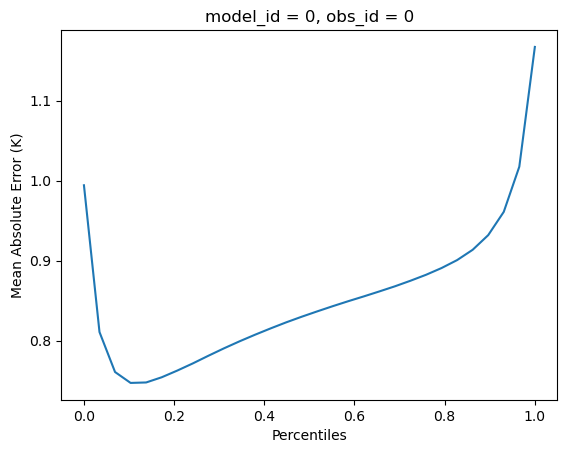

In [45]:
mdm_mae.sel(model_id=0,obs_id=0).plot()
plt.ylabel('Mean Absolute Error (K)')
plt.xlabel('Percentiles')

Text(0.5, 0, 'Percentiles')

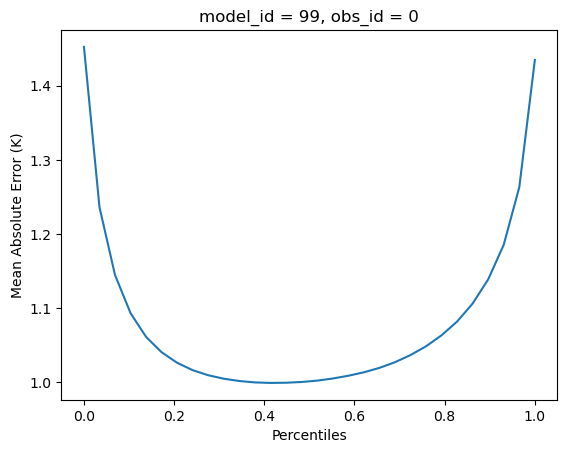

In [46]:
mdm_mae.sel(model_id=99,obs_id=0).plot()
plt.ylabel('Mean Absolute Error (K)')
plt.xlabel('Percentiles')

In [47]:
mdm_mae.sel(model_id=99,obs_id=99).values

array([1.02598436, 0.8380084 , 0.78537408, 0.76926906, 0.76651676,
       0.76976936, 0.77550813, 0.78203248, 0.78889299, 0.79544743,
       0.80195976, 0.80848186, 0.81484332, 0.82132372, 0.82777278,
       0.83446472, 0.84046521, 0.84608348, 0.851807  , 0.85734977,
       0.86272338, 0.8682256 , 0.87343223, 0.87852824, 0.88467788,
       0.89373015, 0.90906753, 0.93694997, 0.99464989, 1.14997224])

### Calculate Mean Absolute Error for sorted QDM

In [48]:
sqdm_abserr = np.fabs(qeoc_obs - qpi_sqdm)
sqdm_mae = global_mean(sqdm_abserr)

In [49]:
%%time
# # sqdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'sqdm_mae_27examples.zarr',mode='w')
# sqdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'sqdm_mae_216examples.zarr',mode='w')
# sqdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'sqdm_mae_100examples.zarr',mode='w')

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 26.7 µs


CPU times: user 403 ms, sys: 66.4 ms, total: 469 ms
Wall time: 536 ms


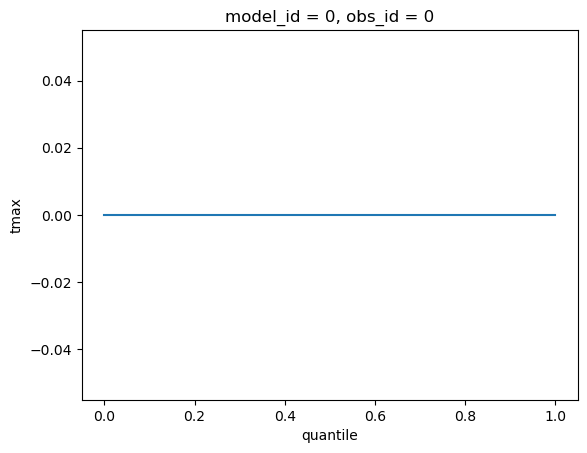

In [50]:
%%time
# sqdm_mae = xr.open_zarr(cvals+'sqdm_mae_27examples.zarr').tmax
# sqdm_mae = xr.open_zarr(cvals+'sqdm_mae_216examples.zarr').tmax
sqdm_mae = xr.open_zarr(cvals+'sqdm_mae_100examples.zarr').tmax
sqdm_mae.sel(model_id=0,obs_id=0).plot()

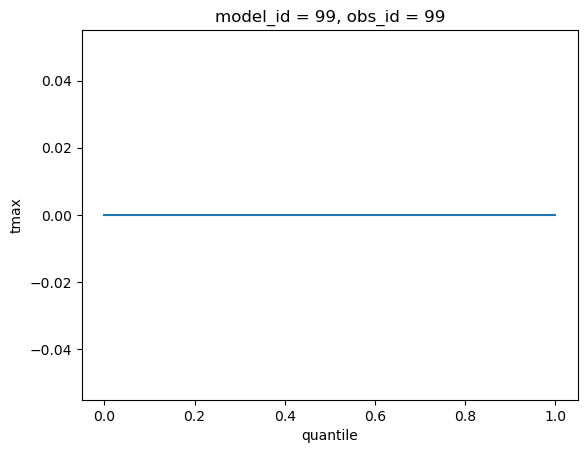

In [51]:
sqdm_mae.sel(model_id=99,obs_id=99).plot()

## Calculate mean of mean absolute error over (obs_id,model_id) pairs 
 - Recall that MAE for a given (obs,model) pair is computed as a global mean and mean overy days of the year.

In [52]:
%%time
mdm_mae_flattened  = mdm_mae.stack(pairs=('obs_id','model_id'),create_index=False)
sqdm_mae_flattened = sqdm_mae.stack(pairs=('obs_id','model_id'),create_index=False)
mdm_mae_flattened

CPU times: user 12.1 ms, sys: 1.99 ms, total: 14.1 ms
Wall time: 12.3 ms


<xarray.DataArray 'tmax' (quantile: 30, pairs: 100)>
dask.array<reshape, shape=(30, 100), dtype=float64, chunksize=(30, 10), chunktype=numpy.ndarray>
Coordinates:
    model_id  (pairs) int64 82 15 4 95 36 32 29 18 99 ... 4 95 36 32 29 18 99 0
    obs_id    (pairs) int64 16 16 16 16 16 16 16 16 ... 99 99 99 99 99 99 99 99
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
Dimensions without coordinates: pairs

In [53]:
average_mdm_mae  = mdm_mae_flattened.mean('pairs')
average_sqdm_mae = sqdm_mae_flattened.mean('pairs')

In [54]:
%%time
# average_mdm_mae.to_dataset().to_zarr(cvals + 'mdm_mae_avg36pairs.zarr',mode='w')
# average_sqdm_mae.to_dataset().to_zarr(cvals + 'sqdm_mae_avg36pairs.zarr',mode='w')
average_mdm_mae.to_dataset().to_zarr(cvals + 'mdm_mae_avg100pairs.zarr',mode='w')
average_sqdm_mae.to_dataset().to_zarr(cvals + 'sqdm_mae_avg100pairs.zarr',mode='w')

CPU times: user 1.23 s, sys: 212 ms, total: 1.45 s
Wall time: 1.92 s


In [55]:
# average_mdm_mae  = xr.open_zarr(cvals + 'mdm_mae_avg36pairs.zarr').tmax
# average_sqdm_mae = xr.open_zarr(cvals + 'sqdm_mae_avg36pairs.zarr').tmax
average_mdm_mae  = xr.open_zarr(cvals + 'mdm_mae_avg100pairs.zarr').tmax
average_sqdm_mae = xr.open_zarr(cvals + 'sqdm_mae_avg100pairs.zarr').tmax

In [56]:
%%time
qano_std_agmean = xr.open_zarr(cvals+'cmip6_quantiles_ano_agmean.zarr').tasmax_qanomaly
qano_std_agmean

CPU times: user 91.1 ms, sys: 14.4 ms, total: 105 ms
Wall time: 98 ms


<xarray.DataArray 'tasmax_qanomaly' (quantile: 30)>
dask.array<open_dataset-4a01f5a189a1fb0ceab2761a3dbe950etasmax_qanomaly, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

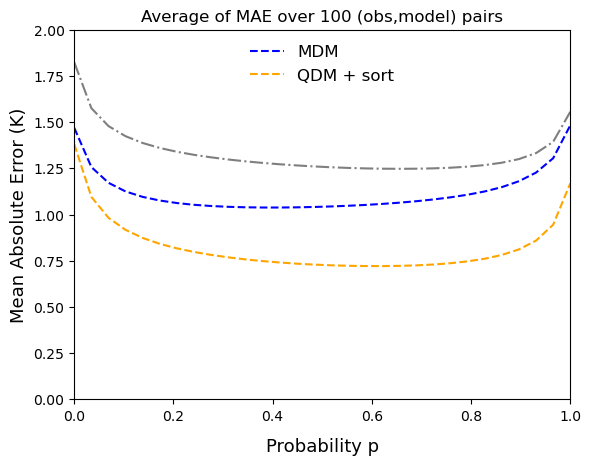

CPU times: user 1.6 s, sys: 128 ms, total: 1.73 s
Wall time: 1.74 s


In [57]:
%%time
quants30        = np.linspace(0,1.0,30)
plt.plot(quants30,average_mdm_mae,'--',label='MDM',color = 'blue')
plt.plot(quants30,average_sqdm_mae,'--',label='QDM + sort',color = 'orange')
plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('Average of MAE over 100 (obs,model) pairs')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()

## Check the sorting function

In [58]:
is_sorted(qpi_sqdm_day.values)

True

In [59]:
is_sorted(qpi_mdm_day.values)

True

In [60]:
%%time
xs.rmse(qeoc_obs_day,qpi_mdm_day).values

CPU times: user 31.5 s, sys: 1.63 s, total: 33.1 s
Wall time: 1min 22s


array(2.7106489)

In [ ]:
%%time
xs.rmse(qeoc_obs_day,qpi_qdm_day).values